### Import Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,r2_score, confusion_matrix,classification_report, mean_squared_error, mean_absolute_error,precision_score,recall_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')



### Load the Dataset

In [2]:
df = pd.read_csv("heart_disease_uci.csv")
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
df.shape

(920, 16)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


### Data Cleaning

In [6]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Let's Impute the missing values of **'float64'** datatype column

In [7]:
# Impute the missing values using IterativeImputer for ca, thalch, oldpeak, chol, 'trestbps'

imputer = IterativeImputer()

columns_to_impute = ['ca', 'thalch', 'oldpeak', 'chol','trestbps']

# Impute the missing values in the specified columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [8]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps      0
chol          0
fbs          90
restecg       2
thalch        0
exang        55
oldpeak       0
slope       309
ca            0
thal        486
num           0
dtype: int64

Let's Impute the missing values of **'Object'** datatype column by using ML Models

In [9]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False).index.tolist()
missing_data_cols

['thal', 'slope', 'fbs', 'exang', 'restecg']

In [10]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [11]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [12]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

thal       486
slope      309
fbs         90
exang       55
restecg      2
dtype: int64

In [13]:
# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 71.26 accuracy

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 65.85 accuracy

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 78.92 accuracy

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 79.19 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 64.13 accuracy



In [14]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

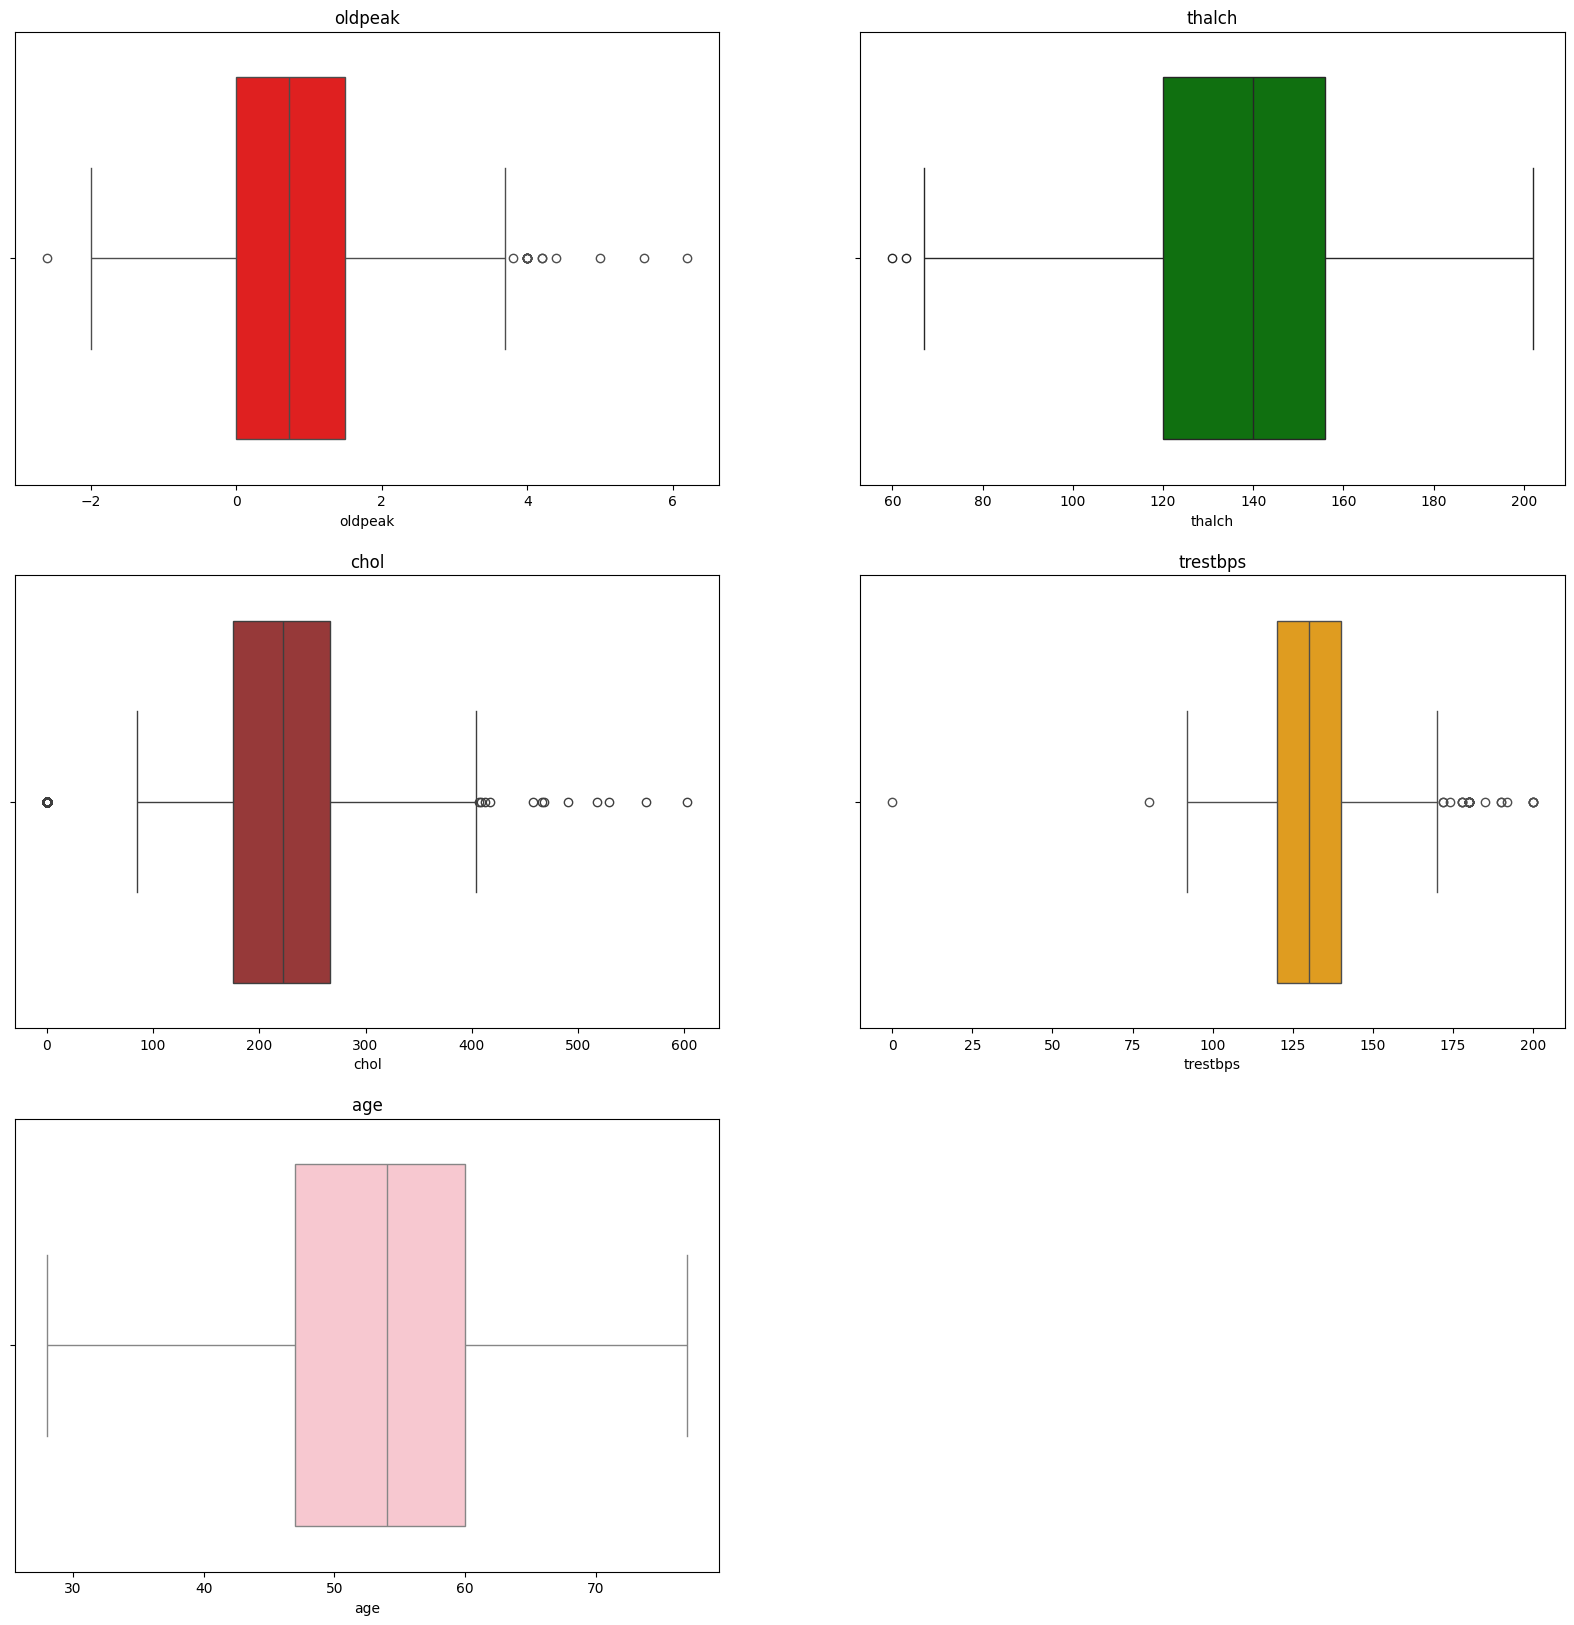

In [15]:
### Handling Outliers

plt.figure(figsize=(20, 20))

colors = ['red', 'green', 'brown', 'orange', 'pink']

for i, col in enumerate(numeric_cols):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col], color=colors[i])
    plt.title(col)
plt.show()

In [16]:
# make box plots of all the numeric columns using for loop and plotly
fig = px.box(data_frame=df, y='age')
fig.show()

fig = px.box(data_frame=df, y='trestbps')
fig.show()

fig = px.box(data_frame=df, y='chol')
fig.show()

fig = px.box(data_frame=df, y='thalch')
fig.show()

fig = px.box(data_frame=df, y='oldpeak')
fig.show()

In [17]:
# print the row from df where trestbps value is 0
df[df['trestbps'] == 0]
# Remove the column because it is an outlier because trestbps cannot be zero.
df = df[df['trestbps'] != 0]

In [18]:
# print the row from df where trestbps value is 0
df[df['trestbps'] == 200]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
126,127,56,Female,Cleveland,asymptomatic,200.0,288.0,True,lv hypertrophy,133.0,True,4.0,downsloping,2.000000,reversable defect,3
548,549,54,Male,Hungary,asymptomatic,200.0,198.0,False,normal,142.0,True,2.0,flat,0.918550,reversable defect,1
680,681,61,Male,Switzerland,non-anginal,200.0,0.0,False,st-t abnormality,70.0,False,0.0,flat,1.403116,normal,3
701,702,64,Female,Switzerland,asymptomatic,200.0,0.0,False,normal,140.0,True,1.0,flat,0.731165,normal,3


### Exploratory Data Analysis

<Axes: xlabel='age', ylabel='Count'>

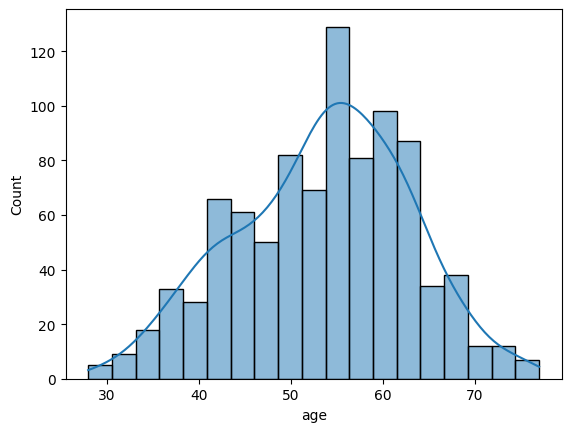

In [19]:
# Plot histogram to see the distribution of with respect to age column
sns.histplot(df['age'], kde=True) 

Mean: 53.50924918389554
Median: 54.0
Mode: 54


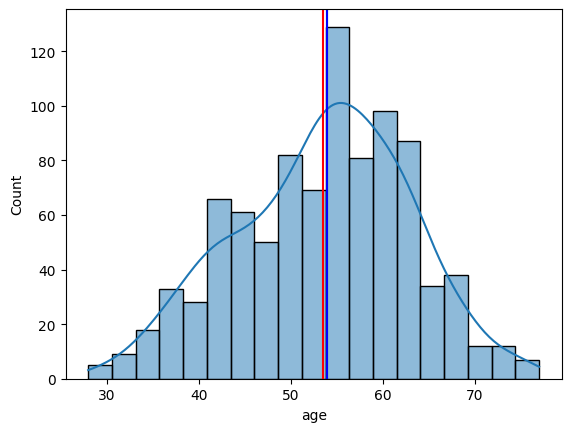

In [20]:
# Plot histogram of age column to find the mean, median, mode by using sns
# `axvline` is a Matplotlib function that adds a vertical line to the plot at a specified x-axis position.

sns.histplot(df['age'], kde=True)
plt.axvline(df['age'].mean(), color='red')
plt.axvline(df['age'].median(), color='green')
#  Since mode returns a Series, [0] is used to get the first mode (assuming there is only one mode).
plt.axvline(df['age'].mode()[0], color='blue')

# print the value of mean, median and mode of age column
print('Mean:', df['age'].mean())
print('Median:', df['age'].median())
print('Mode:', df['age'].mode()[0])

Let's explore the gender based distribution of the dataset for age column

In [21]:
# plot the histogram of age column using plotly and coloring this by sex
fig = px.histogram(data_frame=df, x='age', color='sex')
fig.show()

In [22]:
# find the value of sex column
df['sex'].value_counts()

sex
Male      725
Female    194
Name: count, dtype: int64

In [23]:
# calculate the percentages of male and female value counts in the data
male_count = 726
female_count = 194
total_count = male_count + female_count

# calculate percentages
male_percentage = (male_count / total_count) * 100
female_percentage = (female_count / total_count) * 100

# display the results
print(f"Heart Disease Male percentage in the data: {male_percentage:.2f}%")
print(f"Heart Disease Female Percentage in the data: {female_percentage:.2f}%")

# difference
difference_percentage = ((male_count - female_count) / female_count) * 100
print(f"Males are {difference_percentage:.2f}% more than females in the data.")

Heart Disease Male percentage in the data: 78.91%
Heart Disease Female Percentage in the data: 21.09%
Males are 274.23% more than females in the data.


In [24]:
# find the value count of 'age' column grouped by 'sex' column
df.groupby('sex')['age'].value_counts()

sex     age
Female  54     15
        51     11
        62     10
        43      9
        48      9
               ..
Male    77      2
        28      1
        31      1
        33      1
        76      1
Name: count, Length: 91, dtype: int64

In [25]:
# Let's deal with 'dataset' column
# find the unique values in 'dataset' column

df['dataset'].unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [26]:
# find unique value count in 'dataset' column
df['dataset'].value_counts()

dataset
Cleveland        304
Hungary          293
VA Long Beach    199
Switzerland      123
Name: count, dtype: int64

<Axes: xlabel='dataset', ylabel='count'>

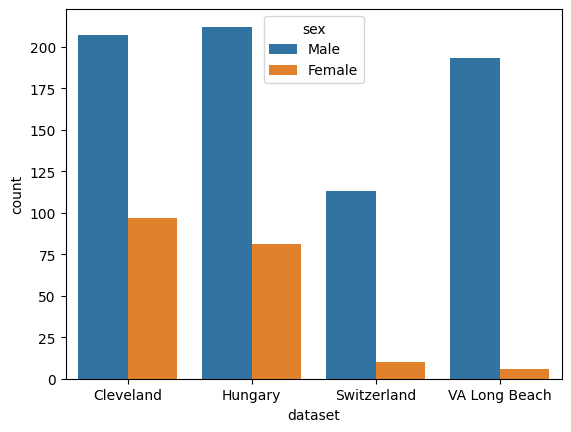

In [27]:
# plot the countplot of 'dataset' column
# get information about the count of heart disease patient 
sns.countplot(data=df, x='dataset', hue="sex")

In [28]:
# We can also plot this with the help of plotly, as the plots of plotly is beautiful for visualizing
fig = px.bar(df, x="dataset", color="sex")
fig.show()

In [29]:
# Value count of 'dataset' column 
df.groupby("sex")['dataset'].value_counts()

sex     dataset      
Female  Cleveland         97
        Hungary           81
        Switzerland       10
        VA Long Beach      6
Male    Hungary          212
        Cleveland        207
        VA Long Beach    193
        Switzerland      113
Name: count, dtype: int64

In [30]:
# Plot the 'age' column using plotly and color this by 'dataset' column
fig = px.histogram(data_frame=df, x='age', color="dataset")
fig.show()

In [31]:
# print the value of mean, median and mode of age column
print('Mean of "Dataset" Column:', df.groupby("dataset")['age'].mean())
print("-----------------------------------------")
print('Median of "Dataset" Column:', df.groupby("dataset")['age'].median())
print("-----------------------------------------")
print('Mode of "Dataset" Column:', df.groupby("dataset")['age'].agg(pd.Series.mode))

Mean of "Dataset" Column: dataset
Cleveland        54.351974
Hungary          47.894198
Switzerland      55.317073
VA Long Beach    59.371859
Name: age, dtype: float64
-----------------------------------------
Median of "Dataset" Column: dataset
Cleveland        55.5
Hungary          49.0
Switzerland      56.0
VA Long Beach    60.0
Name: age, dtype: float64
-----------------------------------------
Mode of "Dataset" Column: dataset
Cleveland              58
Hungary                54
Switzerland            61
VA Long Beach    [62, 63]
Name: age, dtype: object


#### Now Explore 'cp' (Chest Pain) Column

In [32]:
# value count of cp column
df['cp'].value_counts()

cp
asymptomatic       496
non-anginal        203
atypical angina    174
typical angina      46
Name: count, dtype: int64

In [33]:
# Plot the 'cp' column using plotly and color this by 'cp' column
fig = px.histogram(data_frame=df, x='age', color="cp")
fig.show()

<Axes: xlabel='cp', ylabel='count'>

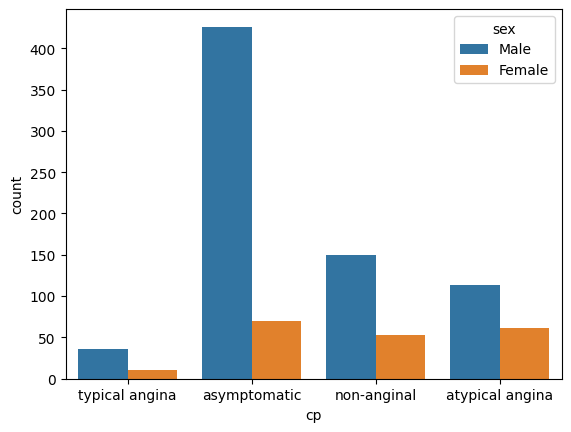

In [34]:
# Count plot with the help of "seaborn"
sns.countplot(df, x="cp", hue="sex")

<Axes: xlabel='cp', ylabel='count'>

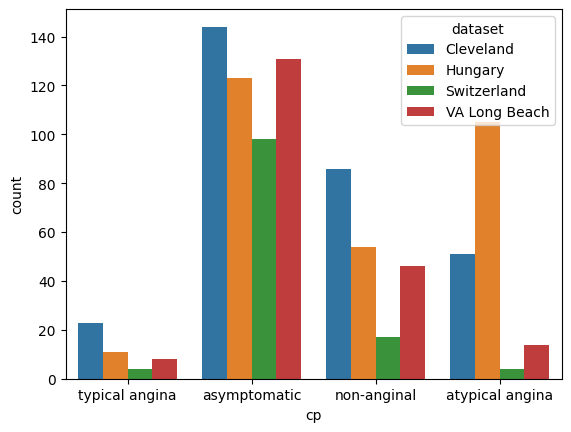

In [35]:
# Count plot with the help of "seaborn"
sns.countplot(df, x="cp", hue="dataset")

In [36]:
# Value count to check that which place has the most 'cp'
df.groupby("dataset")['cp'].value_counts()

dataset        cp             
Cleveland      asymptomatic       144
               non-anginal         86
               atypical angina     51
               typical angina      23
Hungary        asymptomatic       123
               atypical angina    105
               non-anginal         54
               typical angina      11
Switzerland    asymptomatic        98
               non-anginal         17
               atypical angina      4
               typical angina       4
VA Long Beach  asymptomatic       131
               non-anginal         46
               atypical angina     14
               typical angina       8
Name: count, dtype: int64

#### Let's explore the trestbps (rating blood pressure) column:

The normal resting blood pressure is 120/80 mm Hg

In [37]:
# first let's describe the 'trestbps' column

df['trestbps'].describe()

count    919.000000
mean     132.278965
std       17.937612
min       80.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

<Axes: xlabel='trestbps', ylabel='Count'>

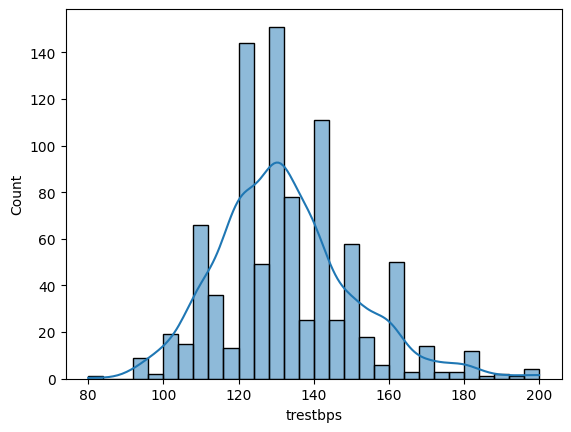

In [38]:
#create a histplot of 'trestbps' column
sns.histplot(df['trestbps'], kde=True)

In [39]:
# plot the 'trestbps' column using plotly
fig = px.histogram(data_frame=df, x="trestbps", color="dataset")
fig.show()

### Encoding

In [40]:
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

encoders = {}

for col in cat_cols:
    lencoder = LabelEncoder()
    df[col] = lencoder.fit_transform(df[col].astype(str))  
    encoders[col] = lencoder

    

In [41]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,2,67,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2
2,3,67,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,4,37,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,5,41,0,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0


### Machine Learning Models

In [42]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

The target column is `num` which is the predicted attribute.We will use this column to predict heart disease.
The unique values in the column are : [0,1,2,3,4] which states that there are five stages of heart diseases.

- **0 = no heart disease** 
- **1 = mild heart disease**
- **2 = moderate heart disease**
- **3 = severe heart disease**
- **4 = critical heart disease**


In [43]:
df['num'].value_counts()

num
0    411
1    265
2    109
3    106
4     28
Name: count, dtype: int64

In [44]:
# Create feature and label 
X = df.drop('num', axis=1)
y = df['num']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Enlist all the models that you will use to predict the heart disease. These models should be classifiers for multi_class classification.

1. logistic regression.
2. SVM
3. Decision Tree
4. Random Forest

### Define Models 

In [45]:
#  Define models and hyperparameter grids

models = {
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {}  # No hyperparams for basic linear model
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100],
            "model__max_depth": [10, 20],
        }
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "model__kernel": ['linear', 'rbf'],
            "model__C": [0.1, 1, 10],
            "model__gamma": ['scale', 'auto']
        }
    },
    'DecisionTree': { 
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "model__min_samples_split": [2, 5, 10],
            "model__max_depth": [None, 10, 20, 30],
        }
    },

}


### Apply GridSearchCV 

In [46]:
# Store results (model name and performance metrics)
results = []
best_accuracy = 0
best_model = None

# Iterate over the models
for name, model_params in models.items():

    # Create pipeline with the current model
    pipeline = Pipeline([

        ('model', model_params['model'])
    ])

    # Hyperparameter tuning
    grid_search = GridSearchCV(pipeline, model_params['params'], cv=5, scoring='accuracy',error_score='raise', n_jobs=-2)

    # Fit on training data
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Store results for current model
    results.append({
        "Model": name,
        "Best Params": grid_search.best_params_,
        "Cross-Validated Accuracy": grid_search.best_score_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred,average='micro'),
        "Recall": recall_score(y_test, y_pred,average='micro'),
        "F1": f1_score(y_test, y_pred,average='micro')
    })

# Track best model
    if grid_search.best_score_ > best_accuracy:
        best_accuracy = grid_search.best_score_
        best_model = grid_search.best_estimator_

# Display best model
print(f"Best Model : {best_model}")
print(f"Best Cross-Validated Accuracy: {best_accuracy:.4f}")

Best Model : Pipeline(steps=[('model',
                 DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                        random_state=42))])
Best Cross-Validated Accuracy: 0.5769


In [47]:
# Final results
results_df = pd.DataFrame(results)
results_df

,Model,Best Params,Cross-Validated Accuracy,Accuracy,Precision,Recall,F1
0,LogisticRegression,{},0.565986,0.494565,0.494565,0.494565,0.494565
1,RandomForest,"{'model__max_depth': 10, 'model__n_estimators'...",0.564626,0.516304,0.516304,0.516304,0.516304
2,SVC,"{'model__C': 1, 'model__gamma': 'auto', 'model...",0.576871,0.548913,0.548913,0.548913,0.548913
3,DecisionTree,"{'model__max_depth': 10, 'model__min_samples_s...",0.556463,0.494565,0.494565,0.494565,0.494565


Best Model: SVC

In [48]:
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(df)

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled2)

In [49]:
df1 = pd.DataFrame(X_pca2, columns =['col1', 'col2'])
df1

,col1,col2
0,-1.856747,-1.858510
1,1.112308,-4.397228
2,0.710501,-3.470201
3,-2.290533,-0.941138
4,-3.823326,-0.712196
...,...,...
914,0.518912,1.538125
915,1.181006,2.521468
916,1.877421,1.805463
917,1.163150,-0.455836


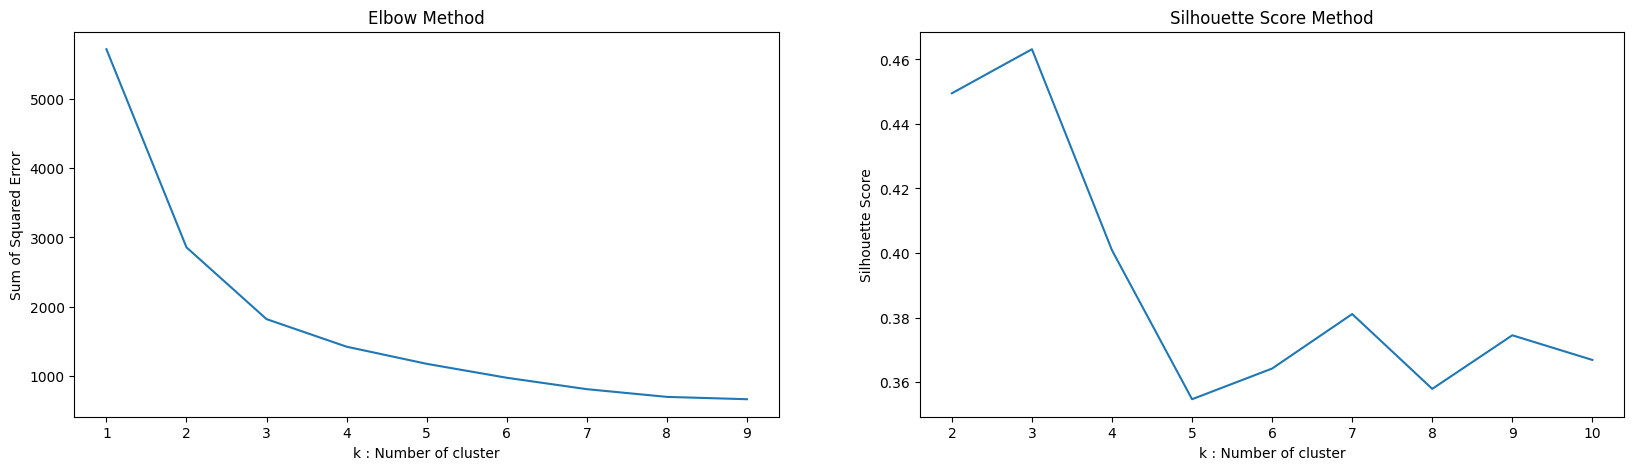

In [50]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(df1)
    labels = kmeans.labels_
    sil.append(silhouette_score(df1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

select
k : Clusters = 3

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca2)
kmeans_silhouette = silhouette_score(X_pca2, y_kmeans)

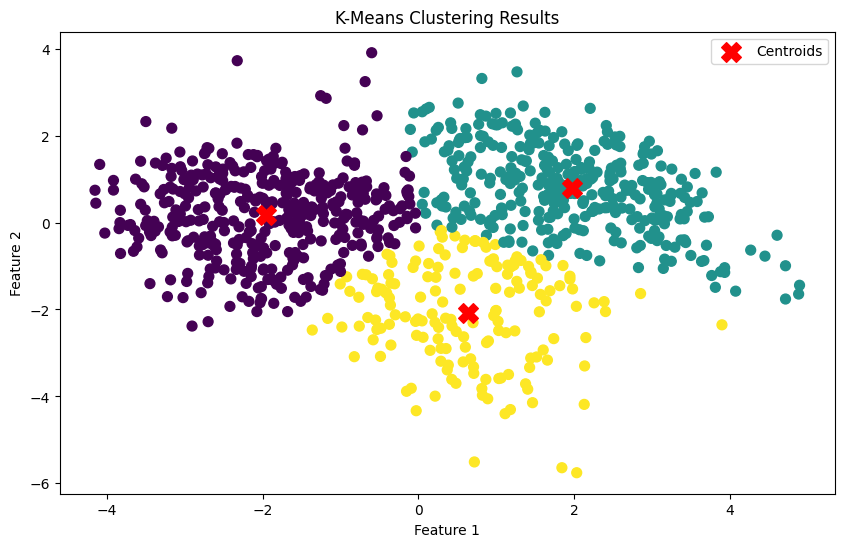

In [52]:
# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_kmeans, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

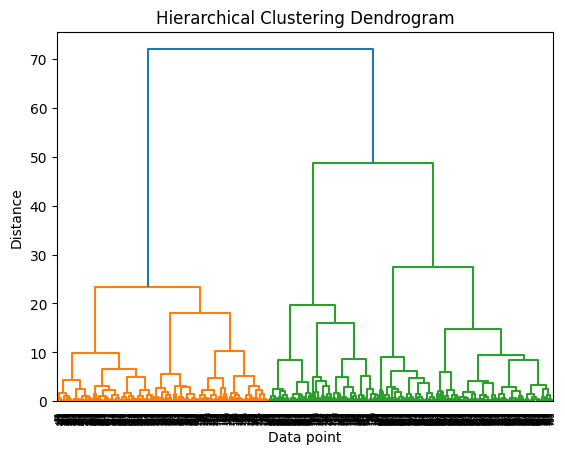

In [ ]:
Z = linkage(X_pca2, 'ward') 

dendrogram(Z)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
plt.show()

In [56]:
# save the best model 
import pickle 
pickle.dump(best_model, open('UciHeartDisease.pkl', 'wb'))